# Unsupervised Graph Learning

Unsupervised ML: subset of ML that do not exploit any target information during training. Where there is no teacher and no correct answer is known a *priori*. These have become a useful tool to solve downstream tasks, such as node classification, community detection etc..

Given a graph, the goal of the techniques is to automatically learn a latent representation of it, in which the key structural components are somehow preserved.

Due to the mathematical complexity of Graphs in non-Euclidean space, it is not always easy to define what is close to what. May be hard to say what *close* even means, two users can be connected yet share very different features, can we still consider them as "close"? So problems like these are the reason unsupervised ML algorithms have found large applications in graph analysis, as there is no need for manually annotated data; making use of the information in the adjacency matrix and node features without any knowledge of the downstream ML task.

One of the most used solutions is to learn embeddings that preserve graph structure. Learned representation can reconstruct pair-wise node similarity e.g. **adjacency matrix**. Can encode latent relationships to discover hidden and complex patterns. Reported by paper https://arxivorg/abs/2005.03675, algorithms can be grouped into macro-groups: shallow embedding methods, autoencoders and GNNs. 

![3_1](./figures/3_1.jpg)

## Shallow Embedding Methods
Learn and return embedding values for learned input data

### Matrix Factorisation
General decomposition technique widely used in different domains. Consistent number of graph embedding algorithms use this technique to compute node embedding of a graph.
Matrix factorisation learns the V and H matrices (W ~ V X H) where $V \in \Re$ <sup>$m$ x $d$</sup> and  $H \in \Re$ <sup>$d$ x $n$</sup> (called **source** and **abundance** matrix respectively) by minimising a loss function that can change according to the specific problem we want to solve. *d* is the number of dimensions of the generated embedding space. The loss fn. is defined by computing the reconstruction err. using the Frobenius Norm as $||W - V X H||^2_F$. 

Generally speaking, all the unsupervised embedding algorithms based on matrix factorisation use the same principle. They factorise an input graph expressed as a matrix in different components. Differences lie in the loss functions used in the optimisation process. Different loss functions create embedding spaces that emphasise specific graph properties.

### Graph Factorisation
GF algorithm factorises the adjacency matrix of a given graph. 
$L = 1/2 \sum\limits_{(i,j) \in E} (A$ <sub>$i,j$</sub> $- Y_i,Y_j^T)^2 + \lambda/2 \sum\limits_{i}||Y_t||^2$
May also include a regularisation term $\lambda$ to make sure the problem remains well-posed in the absence of sufficient data. Suitable for undirected graph, has a strong symmetric factorisation. But could be limited for undirected graphs.

In [1]:
import networkx as nx
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)

# generate d=2 dimensional embedding space
gf = GraphFactorization(d=2, data_set=None, max_iter=10000, eta=1*10**-4, regu=1.0)
# computation of node embeddings of input graph
gf.learn_embedding(graph=G)
# extracted computed embedding by calling gf.get_embedding()
embeddings = gf.get_embedding()

[Errno 2] No such file or directory: 'gem/c_exe/gf'
./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission
		Iter id: 0, Objective: 95.0074, f1: 95.0032, f2: 0.00421903


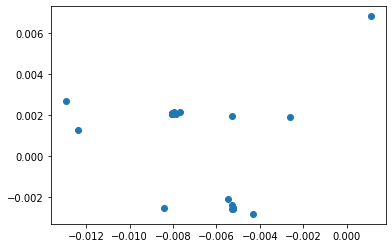

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# we can see approx. 3 groupings
plt.scatter(embeddings[:,0], embeddings[:,1])

**Higher-order proximity preserved embedding (HOPE)** is another graph embedding technique based on matrix factorisation. This method preserves higher-order proximity and does not force its embeddings to have symmetric properties.
-  **First-order proximity**: We say a vertex pair $(v_i, v_j)$ has first-order proximity equal to edge weight $W$<sub>$ij$</sub> if edge $(v_i, v_j) \in E$. Otherwise, the first-order proximity between the two nodes is 0.
-  **Second and high-order proximity**: Capture two-step relationships between each pair of vertices. For each vertex pair $(v_i, v_j)$, second-order proximity is a two-step transition from $v_i$ to $v_j$. Higher-order proximity generalises this and we can capture a more global structure. Higher-order proximity can be viewed as k-step transition from $v_i$ to $v_j$.

Loss function for HOPE is $L = ||S - Y_s \times Y_t^T||^2_F$ where $S$ is the similarity matrix from graph $G$ and $Y_s \in \Re$<sup>$|V|xd$</sup> and $Y_t \in \Re$<sup>$|V|xd$</sup> are two ebedding matrices representing *d*-dimensional embedding space. $Y_s$ represents source embedding and $Y_t$ represents target embedding. HOPE uses two matrices to capture asymmetric proximity in directed networks where the direction from source node and target node is present. The final embedding matrix, Y, is obtained by concatenating column-wise $Y_s$ and $Y_t$ matrices, so the final embedding space has $2 * d$ dimensions.

*S* is a similarity matrix from graph *G*, it's goalis to obtain higher-order proximity information. Formally computed as $S=M_g \cdot M_t$ where $M_g$ and $M_t$ are polynomials of matrices. Some ways to compute $M_g$ and $M_t$ are:
-  **Academic Adar(AA)**: Here, $M_g = I (identity)$ and $M_t = A \cdot D \cdot A$ where $D$ is a diagonal matrix computed as $D$<sub>$ij$</sub> $ = 1/ (\sum (A_i $<sub>$j$</sub> $+ A_j$ <sub>$i$</sub> $))$
-  **Katz Index**
-  **Rooted PageRank (RPR)**
-  **Common Neighbors (CN)** etc..

In [3]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)
# different class initialization with HOPE
# d represents dimension of embedding space, num of columns of final embedding matrix Y
# Y is obtained after column-wise concatenation of Y_s and Y_t
gf = HOPE(d=4, beta=0.01)
gf.learn_embedding(graph=G)
embeddings = gf.get_embedding()

SVD error (low rank): 0.052092


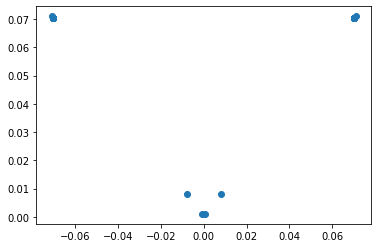

In [4]:
# can see better grouping/separation of models
plt.scatter(embeddings[:,0], embeddings[:,1])

**Graph Representation with Global Structure Information**

Graph representation with global structure information, such as HOPE allows us to preserve higher-order proximity without forcing embeddings to have symmetric properties. Formally, let $G = (V, E)$ be the graph we want to compute node embeddings for and $A \in \Re$<sup>$|V| \times |V|$</sup> be its adjacency matrix, we have the loss function:
$L_k = ||X^k - Y_s^k \times Y_t $<sup>$k^T$</sup>$||^2_F 1 \le k \le K $. In the loss fn, $X^k \in \Re$<sup>$|V|\times|V|$</sup> is a matrix generated from graph *G* to get the *k*th order of proximity between nodes. 

$Y_s^k \in \Re$<sup>$|V|\times|V|$</sup> and $Y_t^k \in \Re$<sup>$|V|\times|V|$</sup> are two embedding matrices representing a d-dimensional embedding space of *k*th order proximity for source and target nodes, respectively. The $X^k$ matrix is computed according to the equation $X^k = \prod\limits_{k}(D$<sup>$-1$</sup>$A)$ where D is a diagonal **degree matrix** computed where $D$<sup>ij</sup>$=\sum\limits_{p} A$<sub>ip</sub> where $i=j$. 

$X^1 = D$<sup>-1</sup>$A$ represents the (one-step) probability transition matrix where Xij is the probability of transition from vertex $V_i$ to $V_j$. Generally, $V^k$<sub>ij</sub> represents the probability of transition from $V_i$ to $V_j$ within *k* steps. For each order of proximity, k, an independent optimisation is fitted. All the k embedding matrices generated are then column-wise concatenated to get the final source embedding matrices.

In [1]:
# node embedding for karateclub
import networkx as nx
from karateclub.node_embedding.neighbourhood.grarep import GraRep

G = nx.barbell_graph(m1=10, m2=4)
# dimensions of embedding space and max num orders of proximity between nodes
gr = GraRep(dimensions=2, order=3) 
gr.fit(G)
# num columns here is dimensions * order
embeddings = gr.get_embedding()

In [2]:
embeddings.shape

(24, 6)

Different orders of proximity allow us to get different embeddings. Since input graph is simple, for *k=1*, a well-separated embedding space is obtained.

### Skip-gram

Skip-gram model is a simple NN with one hidden-layer trained to predict the probability of a given word being present when an input word is present, the NN is trained by building the training data using a text corpus as reference. 

Training: A target word is selected and a rolling window of fixed size *w* is built around the word, the other words inside the rolling window are known as *context* words. So wehave multiple pairs of *(target word, context word)* which are built according to words inside the rolling window.

Once training data is generated from the whole corpus, the skip-gram model is trained to predict the probability of a word being a context word for the given target. During training, the NN learns a compact representation of input words, this is why the model is known as **Word to Vector (Word2Vec)**.

The input is a binary vector of size *m*. Each element of the vector represents a word in the dict of the language we want to embed words in. In training, a *(target word, context word)* pair is given, the input array will have 0 in all its entries with the exception of the entry representing the "target" word which will be 1. The hidden layer has *d* neurons and will learn the embedding representation of each word, creating a *d-*dimensional embedding space.

Finally, output layer is a dense layer of *m* neurons (same size as input vector) with *softmax* activation. Each neuron represents a word of the dictionary and its value corresponds to the probability of that word being "related" to the input word. Since softmax can be hard to compute as *m* increases, a *hierarchical softmax* approach is used.

Our final goal is to not learn the actual task, but to build a compact *d*-dimensional representation of the input words. So we can extract an embedding space for words using the weights of the hidden layer. Another approach is **continuous bag-of-words (CBOW)** which is a context-based skip-gram model. Generally speaking, all unsupervised embedding algorithms based on skip-gram model use the same principle. Start from input graph, they extract from set of walks, these can be seen as a text corpus, whereby connected is a text next to each other. This leads us to DeepWalk.

### DeepWalk

Generates node embeddings of a graph using skip-gram model, for this we introduce **random walk**. Here we select vertex $v_i$ as starting node, then pick neighbour at random and move towards it. We repeat this *t* times so we have random walk of length *t*. There is no guarantee that the local neighbourhood of the node is well preserved as the random walk algorithm has no constraint on how they are built. The *t* walks are used as input to the skip-gram model. The embedding generated by skip-gram will be used as final node embedding. So breaking it down:
1.  **Random Walk Generation**: For each node of input graph G, set of $Y$ random walks with fixed max length (t) is computed. Note that *t* is an upper bound, no constraints forcing all paths to have the same length.
2.  **Skip-Gram Training**: Use walks generated in previous step. When graph is given as input to skip-gram, input can be seen as text corpus where the node is the word of the corpus.
3.  **Embedding Generation**: Information contained in hidden layers of trained skip-gram model is used to extract embedding of each node.

In [51]:
import networkx as nx
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

G = nx.barbell_graph(m1=10, m2=4)
# walk_number: number of random walks to generate for each node
# walk_length: length of the generated random walks
# window_size: window size parameter of the skip-gram model
dw = DeepWalk(dimensions=2)
dw.fit(G)
embeddings = dw.get_embedding()

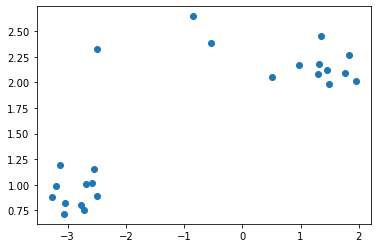

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 

# there is not that clear of a distinction between the embedding space of the nodes
plt.scatter(embeddings[:,0], embeddings[:,1]);

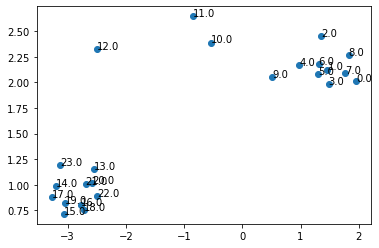

In [53]:
import numpy as np
v_embeddings = np.array([(nid, *embeddings[nid]) for nid in G.nodes])
# separation between nodes is better compared to DeepWalk. Regions 1 and 3 are clustered in space
# region2 is in the middle without overlap with region1 and region3

fig, ax = plt.subplots()
ax.scatter(v_embeddings[:,1], v_embeddings[:,2])

for v in v_embeddings:
    ax.annotate(v[0], (v[1], v[2]))

### Node2Vec
Similar to DeepWalk, generates set of random walks as input to skip-gram and then use hidden layer to generate node embeddings. Difference is in the way random walks are generated.

In Node2Vec, a new technique to generate biased random walks on the graph is introduced. This algorithm combines **Breadth-First Search (BFS)** and **Depth-First Search (DFS)**. These two are regulated by parameters *p* and *q*.
-  **p**: Probability of random walk going back to previous node
-  **q**: probability that random walk passes through previously unseen part of graph

So here Node2Vec can preserve high-order proximities by preserving local graph structures as well as globalcommunity structures. So this preserves local neighbourhood properties of the node.

Computing transition probabilities:   0%|          | 0/24 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 152.76it/s]


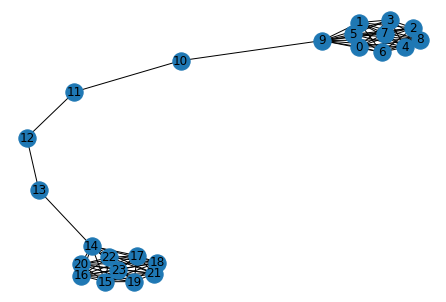

In [2]:
import networkx as nx
from node2vec import Node2Vec
G = nx.barbell_graph(m1=10, m2=4)
nx.draw(G, with_labels=True)
# num walks: number of random walks to generate for each node
# walk_length: length of the generated random walks
# p and q: parameters of the random walk
node2vec = Node2Vec(G, dimensions=2, num_walks=10)
model = node2vec.fit(window=10)
embeddings = model.wv
# can use model.wv[str(nodeId)] to get the embedding of a node

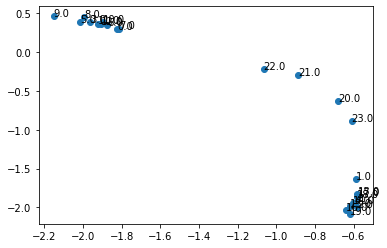

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

v_embeddings = np.array([(nid, *embeddings[nid]) for nid in G.nodes])
# separation between nodes is better compared to DeepWalk. Regions 1 and 3 are clustered in space
# region2 is in the middle without overlap with region1 and region3

fig, ax = plt.subplots()
ax.scatter(v_embeddings[:,1], v_embeddings[:,2])

for v in v_embeddings:
    ax.annotate(v[0], (v[1], v[2]))

### Edge2Vec
Edge2Vec generates embedding space on edges instead of nodes, this uses node embedding of two adjacent nodes to perform some basic mathematical operations in order to extract the embedding of the edge connecting them.

Can compute embeddings with average embedder, Hadamard, Weighted-L1 or Weighted L2

In [6]:
from node2vec.edges import HadamardEmbedder
# value of param is Node2Vec embeding model.
# to change the embedding model, change the value of param
embedding = HadamardEmbedder(keyed_vectors=model.wv)
# different embedding methods create different embeding spaces

### Graph2Vec
Generates embeddings for the whole graph. Generate an embedding space where each point represents a graph, this is an evolution of Word2Vec skip-gram known as **Document to Vector (Doc2Vec)**. Compared to Word2Vec Doc2Vec accepts another binary array representing the document containing the input word. Given a 'target' document and 'target' word, the model tries to predict the most probable 'context' word wrt the input 'target' word and document.

So then with Graph2Vec, we see the entire graph as a document and each of its subgraphs, generated as an ego graph of each node as words that comprise the document. Ie. a graph is composed of subgraphs as a document is composed of sentences, so we summarise the algorithm to the following steps:
1.  **Subgraph Generation**: Set of rooted subgraphs is generated around every node
2.  **Doc2Vec Training**: Doc2Vec skip-gram is trained using the subgraphs generated by the previous step
3.  **Embedding Generation**: Information in hidden layers of Doc2Vec is used to extract embedding of each node


In [11]:
import matplotlib.pyplot as plt
from karateclub import Graph2Vec
import random
n_graphs=20

def generate_random():
    n = random.randint(5, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p)

Gs = [generate_random() for x in range(n_graphs)] # generate 20 watts-strogatz graphs

model = Graph2Vec(dimensions=2) # 2 dimensions
model.fit(Gs) # fit model
embeddings = model.get_embedding() # extract embeddings

More complex graph embedding algorithms based on autoencoders.

## Autoencoders
An autoencoder NN is trained to reconstruct its inputs using a significantly lower number of variables and/or degree of freedom. Autoencoders can learn non-linear transformations thanks to non-linear activation functions of their neurons.
-  **encoder**: Processes input through one or more units and maps it into an encoded representation that reduces the dimension of the inputs and/or constrains its sparsity
-  **decoder**: Reconstructs input signal from encoded representation of middle layer

Encoder-decoder structure is trained to maximise the ability of the full network to reconstruct the input. Some common loss functions ("reconstruction" error), MSE, MAE, Cross-Entropy, KL Divergence.

Tensorflow: Allows one to build symbol structures that describes how inputs are combined to produce outputs, defining **computation graphs** or **stateful dataflow graphs**. Allows one to symbollically differentaiate computation graph WRT any variable, resulting in a new computation graph that can be differentiated also to produce higher-order derivatives. This in the context of optimisation of a loss function WRT many loss functions is central to training of a NN via backpropagation, dubbed as gradient descent.

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# good practice to reduce input precision, will be faster when training
# in some cases can even lower to half-precision (16 bits).
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

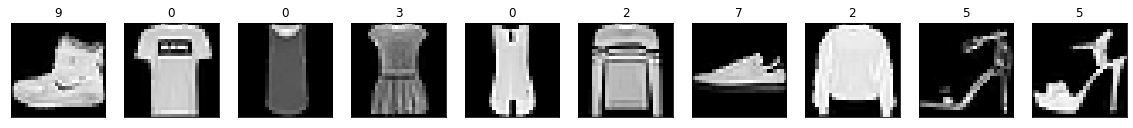

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, Input
input_img = Input(shape=(28, 28, 1))

# define encoder network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) 
x = MaxPooling2D((2, 2), padding='same')(x) # downsamples input
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

2022-07-05 08:48:29.517172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:48:29.608569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:48:29.609282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:48:29.620772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
from tensorflow.keras import Model

Model(input_img, encoded).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [6]:
## decoder network
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # repeats input over a specified window (doubling tensor)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [7]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

In [8]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [10]:
import numpy as np

# reshape
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [11]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [12]:
#import tensorflow as tf
#tf.config.run_functions_eagerly(True) # to make compatible with older versions

autoencoder.fit(
    x_train, x_train, 
    epochs=50, batch_size=128, shuffle=True, 
    validation_data=(x_test, x_test)
    )

Epoch 1/50


2022-07-05 00:40:10.746816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


469/469 [==============================] - 9s 6ms/step - loss: 0.3548 - val_loss: 0.3119
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.3039 - val_loss: 0.3014
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2975 - val_loss: 0.2977
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2942 - val_loss: 0.2952
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2919 - val_loss: 0.2931
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2903 - val_loss: 0.2916
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2888 - val_loss: 0.2902
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2878 - val_loss: 0.2891
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2869 - val_loss: 0.2888
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.2861 - val_loss: 0.2877
Epoch 11/5

In [13]:
decoded_imgs = autoencoder.predict(x_test)

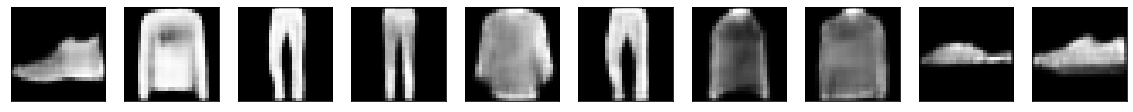

In [14]:
# see what decoded images are produced
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# represent in 2d plane using T-SNE
from tensorflow.keras.layers import Flatten
from sklearn.manifold import TSNE

# get output embeddings
embed_layer = Flatten()(encoded)
embeddings = Model(input_img, embed_layer).predict(x_test)
# reduce to 2d
tsne = TSNE(n_components=2)
emb2d = tsne.fit_transform(embeddings)
print(emb2d.shape)
x, y = np.squeeze(emb2d[:,0]), np.squeeze(emb2d[:,1]) # remove extra dimensions with squeeze

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(10000, 2)


In [16]:
emb2d[:,0].shape, np.squeeze(emb2d[:,0]).shape

((10000,), (10000,))

In [17]:
import random
color_mapping = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(np.unique(y_test)))]
color_mapping_dict = dict(zip(np.unique(y_test), color_mapping))
colours = [color_mapping_dict[abab] for abab in y_test]

In [65]:
color_mapping_dict.keys(), color_mapping_dict.values()

(dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 dict_values(['#58B5CB', '#25EB3A', '#F6983F', '#56DC4D', '#44E5C1', '#2629DF', '#C80750', '#1E7364', '#DEC0C9', '#21BD05']))

In [67]:
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in color_mapping_dict.values()]

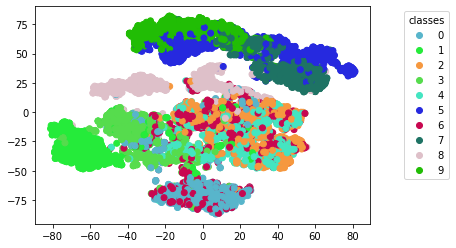

In [79]:
# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, color=colours)
ax.legend(markers, color_mapping_dict.keys(), numpoints=1, title='classes', bbox_to_anchor =(1.25, 1))
plt.show()

 Autoencoders are prone to overfitting as they tend to re-create the images of training and not generalise well. We will see how overfitting can be prevented to build more robust, dense representations.
 ### Denoising Autoencoders
 Autoencoders are also widely used to process a signal to filter out noise and extract only a relevant (characteristic) signal. This can be useful in many applications, such as identifying anomalies and outliers. Denoising autoencoders are a small variation, where some noise of various intensity is added to corrupt the input, whilst keeping the same noise-free target.

In [12]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [15]:
# noisy_autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_train_noisy, x_test))

Approahc is generally valid when datasets are large and the risk of overfitting the noise is limited. When datasets are smaller, an alternative to avoid the network "learning" the noise is to add training stochastic noise using a GaussianNoise layer.

In [ ]:
input_img = Input(shape=(28, 28, 1))
noisy_input = GaussianNoise(0.1)(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(noisy_input)

Now the noisy inputs change between epochs, so the network avoids learning the noise. This is an example of a regularization layer, a layer that helps reduce overfitting by inserting random parts into the network making our model more robust and better at generalising.

Another effective regularisier is dropout, that effectively sets some inputs (with random probability p0) to 0 and rescale other inputs by 1/(1-p0) factor to keep the sum over all units constant. Dropout corresponds to randomly killing some connections between layers to reduce output dependence to specific neurons.

Regularisation layers are only active during training, and at test time simply correspond to identity layers. These help deal with deep NN that tend to overfit and are able to learn identity functions for autoencoders. Often, dropout and GaussianNoise are introduced in a repetitive pattern to have learnable layers referred to as **stacked denoising layers.**

## Graph Autoencoders

Definition of loss function needs to be optimised and a bit of caution when dealing with networks. For Graph Autoencoders, the input and output should be graph representation/ However when dealing with graph structures and adjacency matrices, we see two critical issues:
-  Whereas the presence of links indicates relation or similarity, the absence does not generally indicate a dissimilarity between vertices.
-  The adjacency matrix is extremely sparse, therefore the model will naturally tend to predict 0 rather than a positive value

To address such peculariaties of reconstruction loss, we need to penalise more errors made for the non-zero elements than for zero elements $L_2 = \sum\limits_{i=1}^{n} ||(\tilde(X)_l - Xi)\bigodot b_i||$.

One can promote first-order proximity  by enforcing connected nodes be close in embedding space: $ L_1 = \sum\limits_{i,j=1}^{N} s$<sub>$ij$</sub>$j||y_j - y_i||^2_2$. Here, $y_i$ and $y_j$ are two representation of nodes i and j in embedding space. This loss function forces neighbouring nodes to be close in embedding space. If two nodes are tightly connected, *s*<sub>ij</sub> will be large. Therefore, their difference in embedding space should be limited to keep the loss function small. These two can be combined to a single loss function where we can prevent overfitting with a regularisation loss proportional to the normal of the weight coefficients. 
$L$<sub>$tot$</sub> = $L_t + \alpha \cdot L$<sub>$tot$</sub> + $v \cdot L$<sub>$reg$</sub> = $L_2 + \alpha \cdot L$<sub>$tot$</sub> + $v \cdot ||W||^2_F$ where W represents all weights across the network. And is known as the **Structural Deep Network Embedding (SDNE)**.

In [ ]:
import networkx as nx
import keras
import tensorflow as tf

from gem.embedding.sdne import SDNE
G = nx.karate_club_graph()
sdne = SDNE(d=2, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3, 
            n_units=[50, 15], rho=0.3, n_iter=10, xeta=0.01, n_batch=100,
            modelfile=['enc_model.json', 'dec_model.json'],
            weightfile=['enc_weights.hdf5', 'dec_weights.hdf5'])
sdne.learn_embedding(G)
#embeddings = m1.get_embedding()

Though powerful, we find issues when dealing with larger graphs. For these cases, the autoencoder input is one row of the adjacency matrix that has as many elements as the nodes in the network and can be millions in larger networks. So we can use a different metod over large networks to allow us to scale to larger graphs.

## Graph Neural Networks
**GNNs** are deep learning methods that work on graph-structured data, this family of methods is also known as **geometric deep learning** and is gaining interest in a variety of applications.

The encoder takes as input both the graph structure and node features, these can be trained with or without supervision. The original GNN relies on the fact that each node can be described by its features and its neighbourhood. Information coming from the neighbourhood can be aggregated and used to compute more complex and high-level features.

Initially, each node, $v_i$ is associated with a state. We can start with a random embedding $h_i^t$ (ignoring node attributes for simplicity). At each iteration of the algorithm, nodes accumulate inputs from their neighbours using a simple NN layer:

$h_i^t = \sum\limits_{v_j \in N(v_i)} \sigma(Wh_j$<sup>$t-1$</sup>$+b)$

Here $W \in \Re$<sup>$dxd$</sup> and $b \in \Re ^d$ are trainable parameters where *d* is the dimension of the embedding, $\sigma$ is a non-linear functon and *t* represents the *t-th* iteration of the algorithm. The equation is applied recursively until a particular objective is reached. Note in each iteration, the previous state is exploited to compute the new state (has happened with RNNs).

### Variations of GNNs
With unsupervised representation learning, a common approach is touse an encoder to embed the graph then a simple decoder to reconstruct the adjacency matrix. The loss function is typically formulated as the similarity between the original adjacency matrix and the reconstructed one.

$Z = GNN(X, A)$, $\hat{A} = ZZ^T$ 

Where $A \in \Re$^$N \times N$ is the adjacency matrix representation and $X \in Re$ ^ $N \times d$ is the matrix of node attributes. Another common approach is to train against a *target distance*, so embed two pairs of graphs simultaneously and obtained a combined representation. Trained such that the representation matches the distance. A similar strategy can be adopted with node classification/representation learning.

**Graph Convolution Neural Network (GCN)**: GNN models inspired by CNN; filter parameters shared over locatiions in the graph and several layers are concatenated to form a deep network.

Two types of convolution operations for graph data, **spectral approaches** and **non-spectral (spatial)** approaches. Spectral defines convolutions in spectral domain (decompose graphs in a combination of simpler elements). Spatial convolutions formulates the convolution as aggregating feature information form neighbours.

### Spectral Graph Convolution
Related to spectral graph theory. Characteristics of a graph in relation to the characteristic polynomial, eigenvalues, eigenvectors of the matrices associated with the graph. The convolution operation is defined as the multiplication of a signal (node features) by a kernel. Defined in the Fourier domain by determining the *eigendecomposition f the graph Laplacian*. However this mathematically grounded definition is computationally expensive. So many works have been done o approximate it, such as the Chebyshev polynomial of order K, whichdetermines the locality of the feature. K definining its k-hop neighbourhood (locality of filter).

Let $X \in \Re$<sup>$N \times d$</sup> be the matrix of node features. In classical NN processing, this signal would be composed of layers of the following: 

$H^l = \sigma(XW)$ 

Where $W \in \Re$<sup>$N \times N$</sup> and $\sigma$ is some non-linear activation function. The drawback is that it processes each node signal independently without considering the connections between nodes, so we can make a simple (yet effective) modification:

$H^l = \sigma(AXW)$

By introducing $A \in \Re$<sup>$N \times N$</sup>, a new linear combination between each node and its corresponding neighbours is added. So information depends only on neighbourhood and parameters are applied on all the nodes simultaneously. This operation can be repeated in sequence several times, thus creating a deep NN. At each layer, *X* will be replaced with the output of the previous layer $H$<sup>$l-1$</sup>, though this does have limitations:
-  $A$ considers all neighbours but not itself, so we fix it with $\hat(A) = A + I$ identity matrix
-  Adjacency matrix itself, typically not normalised so we observe large values in feature representation of high-degree nodes and small values in feature representation of small degree nodes. Lead to problems as optimisation algorithms are often sensitive to feature scale. 
    -  Solutions may be to multiply by *diagonal node degree matrix* D, such that all rows sum to 1: $D$<sup>$-1$</sup>$A$. Specifically, they used symmetric normalisation $(D$<sup>$-1/2$</sup>$AD$<sup>$-1/2$</sup>$)$, such that the proposed propagation rule becomes:
    
    $H^l = \sigma(\hat{D}$<sup>$-1/2$</sup>$\hat{AD}$<sup>$-1/2$</sup>$XW)$
    
    Where $\hat{D}$ is the diagonal node degree matrix of $\hat{A}$.

In [47]:
# create GCN as defined in Kipf and Welling, applying to Zachary's Karate Club Graph
import networkx as nx
import numpy as np

G = nx.barbell_graph(m1=10, m2=4)

# create adjacency matrix representing G
A = nx.to_numpy_matrix(G)
# use identity as node descriptor as network has no node features
I = np.eye(G.number_of_nodes())

In [48]:
from scipy.linalg import sqrtm

A_hat = A + I # add self loop

# normalise the adjacency matrix with normalised diagonal node degree matix
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.array(np.diag(D_hat))
D_hat = np.linalg.inv(sqrtm(D_hat)) # inverse sqrt
A_norm = D_hat @ A_hat @ D_hat

In [49]:
def glorot_init(nin, nout):
    # initialise W with glorot uniform initialisation
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer():
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
        
    def forward(self, A, X):
        self._X = (A @ X).T
        H = self.W @ self._X
        H = self.activation(H)
        return H.T # (n_outputs, N)

In [54]:
A_norm.shape, I.shape

((24, 24), (24, 24))

In [50]:
gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

H1 = gcn1.forward(A_norm, I) # 24, 8
H2 = gcn2.forward(A_norm, H1) # 24, 4
H3 = gcn3.forward(A_norm, H2) # 24, 2

# H3 contains the embedding computed using the GCN propagation rule

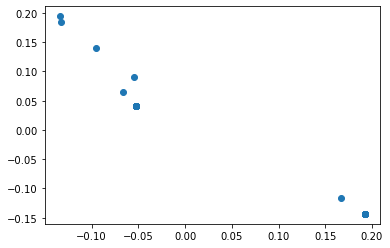

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(np.array(np.squeeze(H3[:,0]))[0], np.array(np.squeeze(H3[:,1]))[0]);

Already looks quite good given we have not trained the network yet.

Results from spectral graph convolutions have achieved noteworthy results in may domains, however have drawbacks. E.g. a big graph with billions of nodes that require simultaneous processing can be impractical from a computational perspective.

Furthermore, spectral convolution assumes a fixed graph leading to poor generalisation on new, different grpahs. So to overcome these issues, spatial graph convolutions present an interesting alternative.

## Spatial Graph Convolution
Spatial graph convolutional networks perform operations directly on graph by aggregating information from spatially close neighbours. Advantages: 
-  Weights can easily be shared across a different location of the graph, leading to good generalisation capability on different graphs
-  Computation can be done by considering subsets of nodes instead of entire graph, potentially improving computational efficiency.

GraphSAGE is an algorithm that implements spatial convolution. One of its main characteristics is its ability to scale over various types of networks, we can think of GraphSAGE as three steps:
1.  **Neighbourhood Sampling**: For each node in the graph, we find its k-neighbourhood, where k is defined as how many hops to consider
2.  **Aggregation**: Aggregate for each node, the node features describing the respective neighbourhood. There are various types of aggregation including pooling, averaging, even more complex such as LSTM..
3.  **Prediction**: Each node is equipped with a simple NN that learns to perform predictions based on aggregated features from neighbours.

GraphSAGE is often used in supervised settings. However, by adopting strategies like using similarity function as target distance, it can also be effecive for learning embedding without explicitly supervising the task.

### In Practice
There are frameworks using TF, Pytorch etc.. We will use StellarGraph.
Graph has two GC layers with 64 and 32 output dimensions followed by RELU. The output will be computed as the euclidean distance of the two embeddings, simply use the laplacian to compute similarity score.

Code is: https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter03/01_Shallow_Embeddings.ipynb


Embedding vectors in an unsupervised manner based on simultaneous embedding of pairs of graphs.

In [1]:
import numpy as np
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model

In [2]:
dataset = sg.datasets.PROTEINS()
graphs, graph_labels = dataset.load()

In [4]:
generator = sg.mapper.PaddedGraphGenerator(graphs)

# define GCN model with 2 layers of size 64 and 32 respectively
# RELU activation fn is used to add non-linearity between layers
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], 
    ['relu', 'relu'],
    generator,
    pool_all_layers=True
)

# retrieve the input and output of the GC layer so they can be connected to next layer
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()
vec_distance = tf.norm(out1 - out2, axis=1)

# create the model. Useful to create a specular model to easily retrieve embeddings
pair_model = Model(inp1 + inp2, vec_distance)
embedding_moel = Model(inp1, out1)

In [12]:
import networkx as nx

def graph_distance(graph1, graph2):
    # graph similarity score between two graphs
    # use distance between spectrum of the laplacian of the graphs
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100,2)) # random indexes to get nodes
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx] # graph distances between graph nodes
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets) # train generator

In [16]:
# compile and train
pair_model.compile(optimizers.Adam(1e-2), loss="mse")
pair_model.fit(train_gen, epochs=500, verbose=1)

Epoch 1/500
10/10 [==============================] - 2s 210ms/step - loss: 269.4668
Epoch 2/500
10/10 [==============================] - 2s 170ms/step - loss: 258.4805
Epoch 3/500
10/10 [==============================] - 2s 200ms/step - loss: 251.7640
Epoch 4/500
10/10 [==============================] - 2s 199ms/step - loss: 251.5001
Epoch 5/500
10/10 [==============================] - 1s 139ms/step - loss: 253.6870
Epoch 6/500
10/10 [==============================] - 2s 180ms/step - loss: 252.2496
Epoch 7/500
10/10 [==============================] - 2s 182ms/step - loss: 250.9616
Epoch 8/500
10/10 [==============================] - 2s 230ms/step - loss: 250.0194
Epoch 9/500
10/10 [==============================] - 2s 169ms/step - loss: 250.7162
Epoch 10/500
10/10 [==============================] - 2s 192ms/step - loss: 247.1717
Epoch 11/500
10/10 [==============================] - 2s 220ms/step - loss: 244.9170
Epoch 12/500
10/10 [==============================] - 2s 162ms/step - loss

In [20]:
# retrieve embeddings
embeddings = embedding_moel.predict(generator.flow(graphs)) # 1113, 96

# TSNE for dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

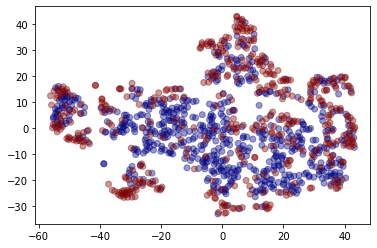

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)
plt.show()
#plt.savefig('embedding_TSNE.png',dpi=300)

Train one of the networks and retrieve embeddings for that one.